# Ocean Parcels Visualisation
Code for plotting Ocean Parcels runs so that you dont have to re-run your simmulation every time

In [1]:
import xarray as xr
from matplotlib import pyplot as plt, animation
import numpy as np
import cmocean as cm
from IPython.display import HTML
from datetime import datetime
from salishsea_tools import geo_tools, places

In [2]:
# Define paths
paths = {
    'coords': '/ocean/rbeutel/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/ocean/rbeutel/MEOPAR/grid/mesh_mask201702.nc',
    'out': './results',
}

In [3]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [4]:
outfile = paths['out']+'/JDFeastBDY20190301_1n_20190306_1n.nc' #need to type in filename here
ds = xr.open_dataset(outfile)

In [5]:
n = 10   # number of particles
clon, clat = -123.541153, 48.224371

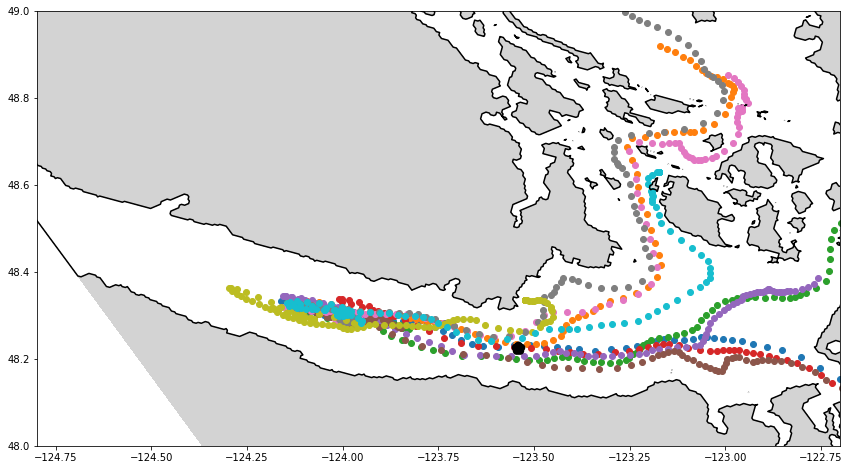

In [6]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmin:nmax], ds.lat[traj, nmin:nmax])
ax.scatter(clon,clat,c='k', marker='*', linewidths=8)

In [7]:
aa = np.zeros(np.shape(ds.lon))
bb = np.zeros(np.shape(ds.lon))

for i in range(n):
    for j in range(np.shape(ds.lon)[1]):
        aa[i,j],bb[i,j] = geo_tools.get_ij_coordinates(ds.lat[i,j],ds.lon[i,j],grid_loc='/data/bmoorema/MEOPAR/grid/grid_from_lat_lon_mask999.nc')
        
og_aa, og_bb = geo_tools.get_ij_coordinates(clat,clon,grid_loc='/data/bmoorema/MEOPAR/grid/grid_from_lat_lon_mask999.nc')

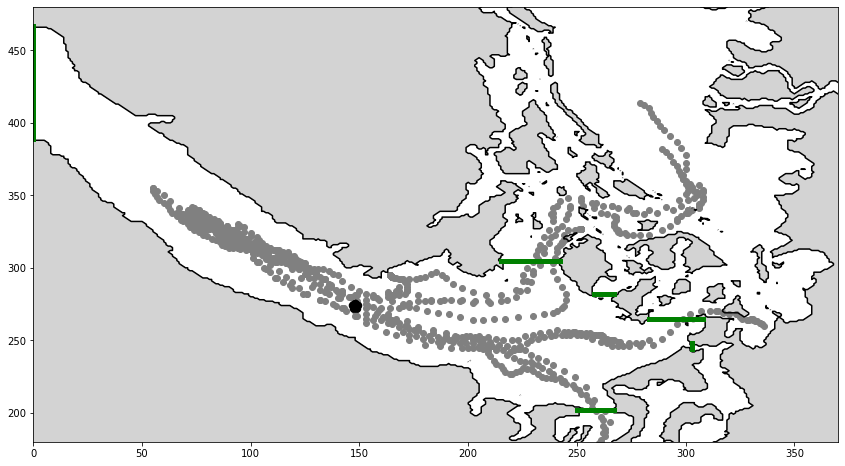

In [28]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([0, 370])
ax.set_ylim([180, 480])
ax.set_aspect(4/6)
nmin, nmax = 0, -1

for traj in range(n):
    s = ax.scatter(aa[traj, nmin:nmax], bb[traj, nmin:nmax],c='grey')
ax.scatter(og_aa,og_bb,c='k', marker='*', linewidths=8)

#add some lines where you think the boundaries should be, boundary 1 is the mouth of the JDF
ax.plot([0,0],[389,467],'g', linewidth = 5, label="boundary 1")
ax.plot([215,242],[305,305],'g', linewidth = 5, label="boundary 2")
ax.plot([283,308],[265,265],'g', linewidth = 5, label="boundary 3")
ax.plot([258,267],[282,282],'g', linewidth = 5, label="boundary 4")
ax.plot([250,267],[202,202],'g', linewidth = 5, label="boundary 5")
ax.plot([303,303],[244,248],'g', linewidth = 5, label="boundary 5")
# ax.legend()

new idea: just remove coords arguments in above plot and it will automatically plot in grid - THEN use geotools code to find grid values for oceanparcels output

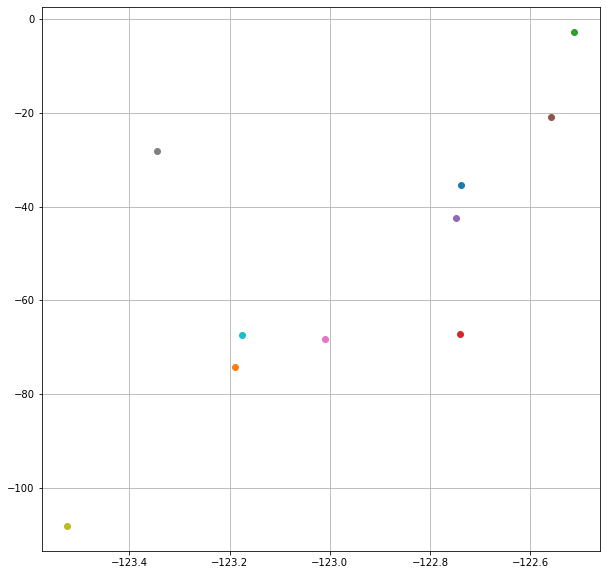

In [36]:
nmax = -1
fig, ax = plt.subplots(figsize=(10, 10))
for traj in range(n):
    ax.plot(ds.lon[traj, nmax], -ds.z[traj, nmax], 'o')
ax.grid()

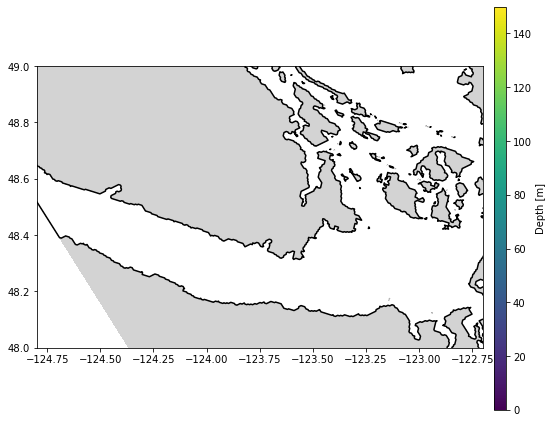

In [8]:
# Make initial figure
fig, ax = plt.subplots(figsize=(8, 8))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=150, edgecolor='k')
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
#data = xr.open_dataset(outfile)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
#ax.set_title('NEMO_3D')
ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
    tstamp = ds.time[0, hour].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l.set_offsets(np.vstack([ds.lon[:, hour], ds.lat[:, hour]]).T)
    l.set_array(ds.z[:, hour])
    return l, t,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=np.shape(ds.time)[1]-1, interval=100, blit=True)

In [9]:
# Render animation
HTML(anim.to_html5_video())